### FOM study (true) via isaura data


You must choose the file inserted here for this to work

In [1]:
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import tables as tb
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers
import iminuit,probfit

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [2]:
#adding here ROI
emin = 1.5
emax = 1.7

#### Collecting all the data

In [3]:

# list of all files in a folder
folder_path = '../LPR_rerun/PORT_1a/prod/isaura/'
#file = f'isaura/isaura_10_228Th.h5'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# NOTE Break this section up, its annoying like this.
dfs = []
df_trs = []
df_ems = []
# create massive dataframe with all of them
for file in file_names:
    file_path = folder_path + file
    df = dstio.load_dst(file_path, 'Tracking', 'Tracks')
    dfs.append(df)
    # include MC particles (boooo takes ages)

    # collecting the correct components of the file, not exactly sure how this works
    df_ps = pd.read_hdf(file_path, 'MC/particles')
    #df_ps = df_ps[df_ps.creator_proc == 'conv']
    # collecting event map
    df_em = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    df_trs.append(df_ps)
    df_ems.append(df_em)

tracks = pd.concat(dfs, axis=0, ignore_index=True)

particles = pd.concat(df_trs, ignore_index=True)
eventmap = pd.concat([dt for dt in df_ems])
# create particle list also

In [4]:
print("Tracks: ")
display(tracks.tail())
print(tracks['event'].nunique())
print("")
print("MC data")
display(particles.tail())
print("")
print("Event map:")
display(eventmap.head())

Tracks: 


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
328458,4060710,0,0.572125,48.927675,59,7484,1,314.675,294.675,522.397217,...,525.821166,349.089849,320.664750,551.769409,0.235944,0.037322,0.000000,9.833333,9.428571,4.456444
328459,4060712,0,0.861342,87.723252,103,6380,4,5.675,415.675,335.498718,...,338.256397,25.904968,465.826742,400.302053,0.169192,0.042754,0.000000,9.500000,8.875000,4.836665
328460,4060712,1,0.026480,4.836665,2,79,4,22.675,478.675,414.213104,...,416.042900,24.629322,478.906839,420.872278,0.026480,0.026480,0.026480,9.500000,8.875000,4.836665
328461,4060712,2,0.001016,8.875000,2,28,4,-6.325,440.675,354.365692,...,354.365692,-3.942128,443.310643,354.365692,0.001016,0.001016,0.001016,9.500000,8.875000,4.836665
328462,4060712,3,0.000585,0.000000,1,18,4,65.675,424.675,350.184662,...,350.184662,67.733877,426.232716,350.184662,0.000585,0.000585,0.000585,9.500000,8.875000,4.836665


100009

MC data


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
8041796,2030356,91,e-,False,55,30.259228,426.134430,352.008423,2.193173,30.096209,...,-0.162406,0.015503,-0.008732,0.0,0.0,0.0,0.025482,1.436975,eIoni,eIoni
8041797,2030356,90,e-,False,55,30.279558,429.029327,353.054474,2.120956,30.183689,...,0.064169,0.157650,0.102301,0.0,-0.0,-0.0,0.037231,2.202024,eIoni,eIoni
8041798,2030356,89,e-,False,55,32.744003,438.281555,344.038391,1.840851,32.722652,...,-0.022657,0.085612,0.095038,0.0,0.0,-0.0,0.016253,0.597368,eIoni,eIoni
8041799,2030356,88,e-,False,55,23.930265,443.683899,364.208191,1.648568,23.785473,...,-0.025266,-0.164843,-0.084782,-0.0,0.0,-0.0,0.033170,1.671516,eIoni,eIoni
8041800,2030356,53,Pb208,False,36,396.074768,394.611877,530.918335,0.000739,396.078827,...,2.427084,-0.653481,0.719626,0.0,-0.0,0.0,0.000018,0.004373,RadioactiveDecay,NoProcess



Event map:


,evt_number
nexus_evt,
2540000,5080000
2540001,5080002
2540002,5080004
2540003,5080006
2540004,5080008


#### Checking that the MC data indexing is just half the track index, and matching the indices accordingly

In [6]:
# double check that this is a valid solution

eventmap_reset = eventmap.reset_index()
display(eventmap_reset)

if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here!")
else:
    print("No Falses to be seen!")

,nexus_evt,evt_number
0,2540000,5080000
1,2540001,5080002
2,2540002,5080004
3,2540003,5080006
4,2540004,5080008
...,...,...
100004,2030352,4060704
100005,2030353,4060706
100006,2030354,4060708
100007,2030355,4060710


No Falses to be seen!


In [7]:
# So we're updating it here
particles['event_id'] = particles['event_id'] * 2 
display(particles.head())

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080000,1,Tl208,True,0,397.564026,392.015442,534.536865,0.000000,397.564026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
1,5080000,4,e-,False,1,397.564026,392.015442,534.536865,0.001609,407.646332,...,0.866701,-0.327340,0.002752,-0.000000,-0.000000,0.000000,0.547042,32.554752,RadioactiveDecay,eIoni
2,5080000,3,anti_nu_e,False,1,397.564026,392.015442,534.536865,0.001609,11181.164062,...,0.723798,-0.865316,0.547861,0.723798,-0.865316,0.547861,1.254116,18684.607422,RadioactiveDecay,Transportation
3,5080000,2,Pb208[3197.711],False,1,397.564026,392.015442,534.536865,0.001609,397.564026,...,-1.590499,1.192656,-0.550613,-0.000000,0.000000,-0.000000,0.000011,0.000000,RadioactiveDecay,RadioactiveDecay
4,5080000,6,gamma,False,2,397.564026,392.015442,534.536865,0.001609,164.141830,...,-0.455762,0.228695,0.282998,-0.000000,0.000000,-0.000000,0.583188,1501.569824,RadioactiveDecay,phot


#### Select a specific event just to check for anything weird happening

In [8]:
# select a specific event
n = 2
evnt = tracks.event.unique()[n]
print("Event of interest: {}".format(evnt))

trk = tracks[tracks.event==evnt]
trk.head()

Event of interest: 5080004


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,5080004,0,0.475175,32.04773,19,4159,4,12.675,-316.325,147.604263,...,154.888442,26.338924,-287.808455,155.155294,0.392980,0.362969,0.280775,10.0,9.222222,4.83697
14,5080004,1,0.000826,0.00000,1,28,4,36.675,-259.325,154.847458,...,154.847458,38.559927,-256.434284,154.847458,0.000826,0.000826,0.000826,10.0,9.222222,4.83697
15,5080004,2,0.000476,0.00000,1,21,4,22.675,-336.325,159.047852,...,159.047852,24.360200,-334.110790,159.047852,0.000476,0.000476,0.000476,10.0,9.222222,4.83697
16,5080004,3,0.000204,0.00000,1,12,4,69.675,-285.325,153.809357,...,153.809357,71.210282,-284.312488,153.809357,0.000204,0.000204,0.000204,10.0,9.222222,4.83697


#### Starting the cuts here

The below cell includes all the required functions for cutting and beyond

In [9]:
def cut_effic(df1, df2, verbose = False):
    '''
    Prints efficiency of cuts for singular cut
    df1 -> cut df
    df2 -> initial df
    '''
    length_1 = df1['event'].nunique()
    length_2 = df2['event'].nunique()
    efficiency = ((length_1/length_2)*100)
    print("Efficiency: {:.2f} %".format(efficiency))

    if (verbose == True):
        print(("Events in reduced dataframe: {}\nEvents in initial dataframe: {}").format(len(df1), len(df2)))

    return efficiency




def plot_hist(df, column = 'energy', binning = 20, title = "Energy plot", output = True, fill = True, label = 'default', x_label = 'energy (MeV)', range = 0, data = False):
    '''
    Print a histogram of energy from our dataframe,.
    '''
    # for simplicity/readability, scoop out the relevant columns from the pandas dataframe.
    energy_vals = df[column].to_numpy()

    if (range==0):
        range = (np.min(energy_vals), np.max(energy_vals))

    # control viewing of hist
    if (fill == True):
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, range = range)
    else:
        cnts, edges, patches = plt.hist(energy_vals, bins = binning, label = label, histtype='step', linewidth = 2, range = range)
    plt.title(title)
    plt.ylabel("events")
    plt.xlabel(x_label)
    if (output==True):
        plt.show()
    if (data==True):
        return (cnts, edges, patches)
    else:
        return




def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False):
    '''
    Produces fiducial track cuts while removing all events that have outer fiducial tracks
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low['event'].to_numpy())
    up_list = (z_df_up['event'].to_numpy())
    r_list = (r_df['event'].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df['event'].isin(low_list)]
    df2 = df1[~df1['event'].isin(up_list)]
    df3 = df2[~df2['event'].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3




def one_track_cuts(df, verbose = False):
    '''
    Remove events with more than one track
    THERE IS A COLUMN WITH THIS INFO IN IT, CALCULATING IT IS UNNECESSARY
    '''
    # 1-track event counter
    event_counts = df.groupby('event').size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df['event'].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events




def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with energy overlap != 0
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove




def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False):
    '''
    Apply cuts around the relevant energy
    '''
    filt_e_df = df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)]

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return filt_e_df




def len_events(df):
    '''
    Returns the number of unique events as len(df) doesn't work in this case
    '''
    length_1 = df['event'].nunique()
    return length_1




def plot_volume_hists(df):

    plot_hist(df, column = 'x_min', output = False, label = 'x_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'x_max', title = 'x plot for full volume', output = False, label = 'x_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'y_min', output = False, label = 'y_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'y_max', title = 'y plot for full volume', output = False, label = 'y_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

    plot_hist(df, column = 'z_min', output = False, label = 'z_min', fill = False, x_label = 'position (mm)')
    plot_hist(df, column = 'z_max', title = 'z plot for full volume', output = False, label = 'z_max', fill = False, x_label = 'position (mm)')
    plt.legend(loc='upper left')
    plt.show()

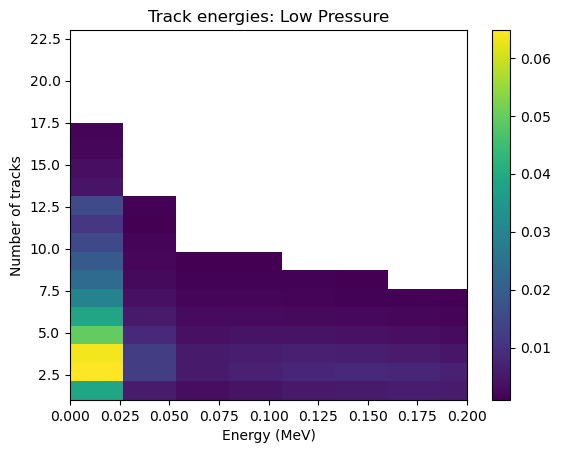

In [15]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = tracks.energy
track_no = tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 20), cmin=0.001)
plt.xlim([0,0.2])
plt.title("Track energies: Low Pressure")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.colorbar()
plt.show()

### Remove low energy events

In [17]:
def remove_low_E_events(df, energy_limit = 0.05):
    '''
    Remove low energy tracks, add their energy back to the first
    track and then update 'numb_of_tracks' to be up to date
    '''

    tracks_test = df.copy(deep=True)

    # take events with lower than 50 keV, 0.05 MeV
    condition = (tracks_test.energy < energy_limit)
    summed_df = tracks_test[condition].groupby('event')['energy'].sum().reset_index()

    # merge these as a new column
    merged_df = pd.merge(tracks_test, summed_df, on='event', suffixes=('', '_sum'))

    # add this summed energy to first column
    merged_df['energy'] = merged_df.apply(lambda row: (row['energy'] + row['energy_sum']) if row.name == merged_df[merged_df['event'] == row['event']].index[0] else row['energy'], axis=1)

    # drop energy sum column
    result_df = merged_df.drop('energy_sum', axis = 1)

    # then remove all tracks below the energy threshold
    condition_upper = (result_df.energy > energy_limit)
    remove_low_E = result_df[condition_upper]

    # count the number of events identified with unique event, and change numb_of_tracks to reflect this
    event_counts = remove_low_E['event'].value_counts(sort = False)

    # apply this to numb_of_tracks
    remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)

    return remove_low_E

##### Cuts

We want to:
- Remove low energy events (as shown above)
- Include events within the fiducial volume [r < 472mm; 20 mm < z < 1195mm]
- only include 1-track events
- No overlapping blobs
- Energy cut for thallium [1.5, 1.7] MeV


### Low energy cut

In [18]:
# Low energy cut
display(tracks.head(10))
low_e_cut_tracks = remove_low_E_events(tracks)
display(low_e_cut_tracks.head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.039447,106.957101,130,10660,4,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
1,5080000,1,0.013352,4.809897,2,47,4,388.675,270.675,440.460083,...,441.936821,389.120948,279.638220,446.759552,0.013352,0.013352,0.013352,9.857143,9.928571,4.809897
2,5080000,2,0.010388,0.000000,1,65,4,378.675,254.675,408.962036,...,409.787137,381.749030,256.750470,409.787137,0.010388,0.010388,0.010388,9.857143,9.928571,4.809897
3,5080000,3,0.001319,0.000000,1,21,4,378.675,254.675,424.692047,...,424.692047,381.261911,256.890582,424.692047,0.001319,0.001319,0.001319,9.857143,9.928571,4.809897
4,5080002,0,0.962756,77.756812,74,5810,9,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,9,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,9,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,9,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
8,5080002,4,0.074157,14.532390,5,290,9,-20.325,376.675,587.473511,...,594.815981,-4.176398,379.414310,588.386162,0.074157,0.074157,0.074157,9.750000,9.571429,4.951324
9,5080002,5,0.017627,10.776263,2,32,9,28.675,347.675,555.981140,...,560.994456,28.675000,360.638246,555.981140,0.017627,0.017627,0.017627,9.750000,9.571429,4.951324


/tmp/ipykernel_34136/261361389.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.064505,106.957101,130,10660,1,368.675,160.675,334.439758,...,346.618662,395.709598,257.212595,386.899102,0.549273,0.021990,0.000000,9.857143,9.928571,4.809897
4,5080002,0,0.990687,77.756812,74,5810,5,-87.325,359.675,612.663391,...,648.421388,-43.764823,403.787828,615.673530,0.306094,0.030088,0.000000,9.750000,9.571429,4.951324
5,5080002,1,0.731305,74.337640,72,4647,5,-98.325,411.675,604.282959,...,649.717506,-93.095078,423.334631,611.416833,0.375550,0.144682,0.000000,9.750000,9.571429,4.951324
6,5080002,2,0.168541,20.685177,10,850,5,127.675,353.675,498.257599,...,501.543143,131.322157,369.363285,505.352041,0.166143,0.145188,0.142790,9.750000,9.571429,4.951324
7,5080002,3,0.140927,58.630464,23,793,5,52.675,348.675,513.979492,...,516.101429,53.955545,349.802676,526.248103,0.088264,0.021532,0.000000,9.750000,9.571429,4.951324
8,5080002,4,0.074157,14.532390,5,290,5,-20.325,376.675,587.473511,...,594.815981,-4.176398,379.414310,588.386162,0.074157,0.074157,0.074157,9.750000,9.571429,4.951324
13,5080004,0,0.476680,32.047730,19,4159,1,12.675,-316.325,147.604263,...,154.888442,26.338924,-287.808455,155.155294,0.392980,0.362969,0.280775,10.000000,9.222222,4.836970
17,5080008,0,0.342280,24.071850,14,2603,2,214.675,207.675,251.550385,...,254.884531,226.959512,217.030879,268.335009,0.308192,0.307513,0.303585,9.166667,9.684211,4.927902
18,5080008,1,0.115869,10.865917,3,790,2,241.675,346.675,439.461395,...,441.972932,246.387016,360.039896,445.648195,0.115869,0.115869,0.115869,9.166667,9.684211,4.927902
20,5080010,0,1.271544,77.117883,103,10104,2,-88.325,56.675,1118.789551,...,1120.857091,-52.379341,61.995799,1160.489484,0.505458,0.074204,0.000000,9.222222,9.942857,4.964774


65766


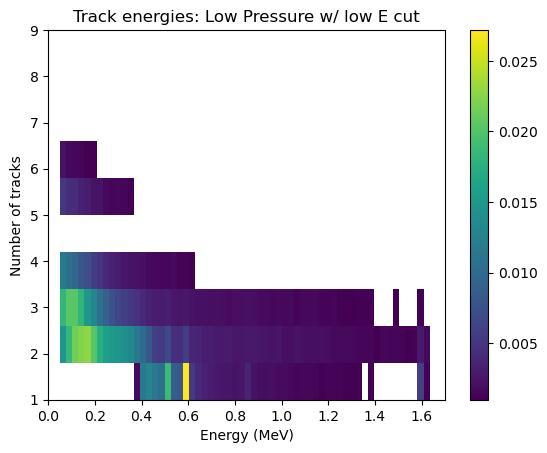

In [33]:
print(len_events(low_e_cut_tracks))

track_energy = low_e_cut_tracks.energy
track_no = low_e_cut_tracks.numb_of_tracks
# normalise
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(100, 10), cmin=0.001)
plt.title("Track energies: Low Pressure w/ low E cut")
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.xlim([0,1.7])
plt.colorbar()
plt.show()

In [22]:
# Efficiency calculation
cut_names = []
rel_cut_effics = []
abs_cut_effics = []
cut_events = []

# no cuts
cut_names.append("No cuts")
rel_cut_effics.append(100)
abs_cut_effics.append(100)
# number of events
cut_events.append(len_events(tracks))


# low energy cut
cut_names.append("low E cuts")

# make efficiency calculation
print("Low E cut")
print("==================")
ef = cut_effic(low_e_cut_tracks, tracks)

# add efficiency calculation
rel_cut_effics.append(ef)
cut_events.append(len_events(low_e_cut_tracks))
abs_cut_effics.append(ef)

Low E cut
Efficiency: 65.76 %


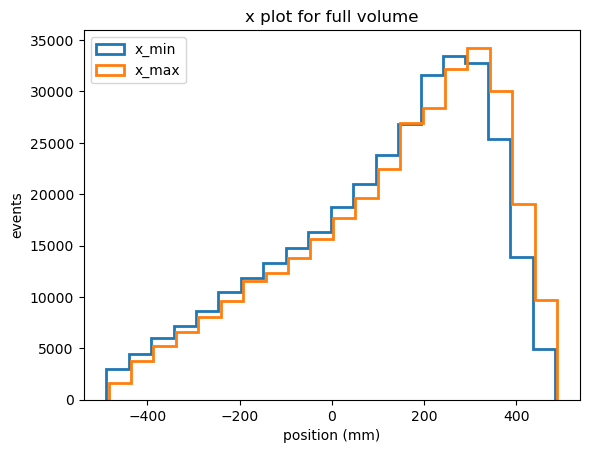

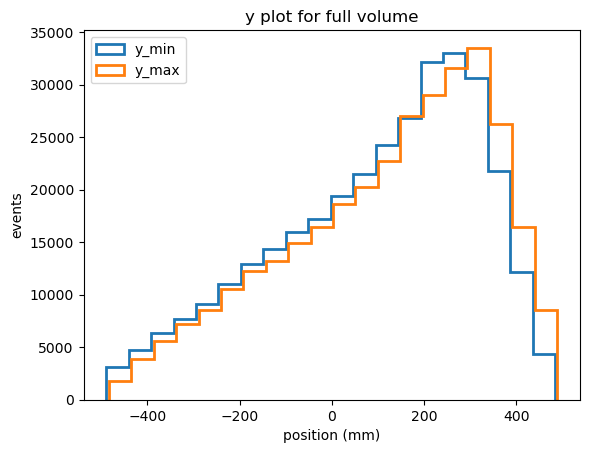

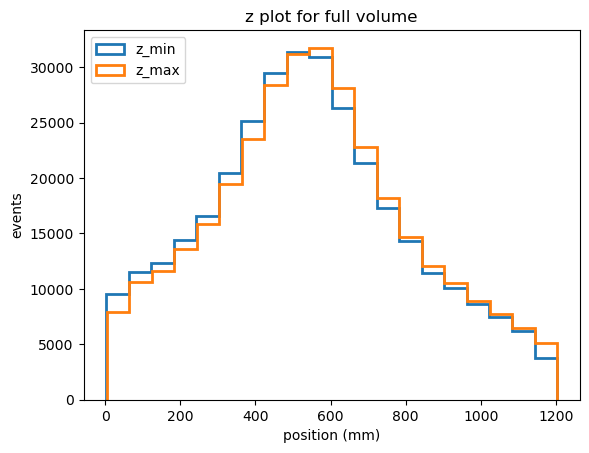

In [23]:
# plotting the positional histograms
plot_volume_hists(tracks)

# Fiducial cuts

In [24]:


cut_names.append("Fiducial Cuts")

# make fiducial cuts
fiducial_rel = fiducial_track_cut_2(low_e_cut_tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = False)

fiducial_abs = fiducial_track_cut_2(tracks, lower_z = 20, upper_z=1195, r_lim = 472, verbose = True)

# make efficiency calculation
print("Fiducial track cut")
print("==================")
print("Relative Cut efficiency:")
ef = cut_effic(fiducial_rel, low_e_cut_tracks)
rel_cut_effics.append(ef)
cut_events.append(len_events(fiducial_rel))

print('Absolute Cut efficiency:')
ef = cut_effic(fiducial_abs, tracks)
abs_cut_effics.append(ef)


Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 472
Fiducial track cut
Relative Cut efficiency:
Efficiency: 70.63 %
Absolute Cut efficiency:
Efficiency: 66.76 %


# One track cut

In [25]:
# relative

cut_names.append("One track cut")
one_track_rel = one_track_cuts(fiducial_rel, verbose = False)

# events are relative, as absolute efficiency lets you figure out events from the beginning# absolute
one_track_abs = one_track_cuts(tracks)

## sanity check here
#print(len_events(one_track_rel), len_events(one_track_abs), len_events(tracks))

# relative
print("Single track cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(one_track_rel, fiducial_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(one_track_rel))

# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(one_track_abs, tracks)
abs_cut_effics.append(ef)

Single track cut
Relative Cut efficiency:
Efficiency: 43.37 %
Absolute Cut efficiency:
Efficiency: 17.97 %


# Overlapping blob cuts

In [26]:
# apply cuts
ovlp_rel = overlapping_cuts(one_track_rel)
ovlp_abs = overlapping_cuts(tracks)

cut_names.append("Blob overlap cuts")

# relative
print("Blob overlap cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ovlp_rel, one_track_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ovlp_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ovlp_abs, tracks)
abs_cut_effics.append(ef)

Blob overlap cut
Relative Cut efficiency:
Efficiency: 50.19 %
Absolute Cut efficiency:
Efficiency: 53.24 %


# Energy cut

In [27]:
ecut_rel = energy_cuts(ovlp_rel)
ecut_abs = energy_cuts(tracks)

cut_names.append("Energy cuts")

# relative
print("Energy cut")
print("================")
print("Relative Cut efficiency:")
ef = cut_effic(ecut_rel, ovlp_rel)
rel_cut_effics.append(ef)
cut_events.append(len_events(ecut_rel))


# absolute
print("Absolute Cut efficiency:")
ef = cut_effic(ecut_abs, tracks)
abs_cut_effics.append(ef)

Energy cut
Relative Cut efficiency:
Efficiency: 11.90 %
Absolute Cut efficiency:
Efficiency: 5.07 %


In [28]:
efficiencies = pd.DataFrame({'Cut': cut_names,
                             'Relative Efficiency': rel_cut_effics,
                             'Relative Events': cut_events,
                             'Single Cut Efficiency': abs_cut_effics
                             })

display(efficiencies)
print("Single Cut Efficiency: each cut on the original unmodified data set\nRelative Efficiency: each cut efficiency wrt the previous cut")

,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,100009,100.000000
1,low E cuts,65.760082,65766,65.760082
2,Fiducial Cuts,70.627680,46449,66.763991
3,One track cut,43.367995,20144,17.972382
4,Blob overlap cuts,50.193606,10111,53.236209
5,Energy cuts,11.897933,1203,5.066544


Single Cut Efficiency: each cut on the original unmodified data set
Relative Efficiency: each cut efficiency wrt the previous cut


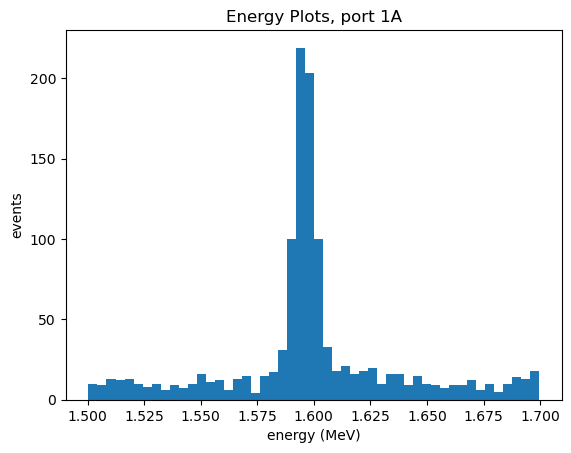

In [30]:
# just for visualising it
plot_hist(ecut_rel, binning = 50, title = 'Energy Plots, port 1A')


In [32]:
display(low_e_cut_tracks[low_e_cut_tracks['numb_of_tracks'] == 2].head(10))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
17,5080008,0,0.342280,24.071850,14,2603,2,214.675,207.675,251.550385,...,254.884531,226.959512,217.030879,268.335009,0.308192,0.307513,0.303585,9.166667,9.684211,4.927902
18,5080008,1,0.115869,10.865917,3,790,2,241.675,346.675,439.461395,...,441.972932,246.387016,360.039896,445.648195,0.115869,0.115869,0.115869,9.166667,9.684211,4.927902
20,5080010,0,1.271544,77.117883,103,10104,2,-88.325,56.675,1118.789551,...,1120.857091,-52.379341,61.995799,1160.489484,0.505458,0.074204,0.000000,9.222222,9.942857,4.964774
21,5080010,1,0.142156,10.473699,4,1120,2,-84.325,355.675,578.050293,...,580.458542,-73.057690,361.110007,583.747191,0.142156,0.142156,0.142156,9.222222,9.942857,4.964774
47,5080020,0,1.893940,196.647742,225,11614,2,253.675,149.675,367.020935,...,466.688660,287.706937,161.637783,399.086752,0.115920,0.028134,0.000000,9.272727,9.842105,4.969414
48,5080020,1,0.204253,49.680511,26,1214,2,314.675,287.675,512.918396,...,517.890633,345.111094,330.487001,532.282374,0.103916,0.057766,0.000000,9.272727,9.842105,4.969414
75,5080042,0,0.782268,67.584491,82,6541,2,-133.325,-74.325,756.522827,...,773.263561,-105.325000,-11.830532,760.730286,0.549755,0.032951,0.000000,9.111111,9.500000,4.898193
76,5080042,1,0.196961,108.759390,71,1878,2,-104.325,-57.325,673.573486,...,731.312683,-68.349143,-10.329017,673.573486,0.034387,0.031304,0.000000,9.111111,9.500000,4.898193
84,5080050,0,0.244963,14.913095,5,1352,2,245.675,95.675,107.699036,...,110.803996,258.291790,101.760858,113.083777,0.214040,0.214040,0.214040,9.978723,9.913043,4.955506
85,5080050,1,0.158183,14.913095,8,1896,2,-194.325,-83.325,489.836517,...,492.552351,-181.709082,-70.599370,496.514626,0.158183,0.158183,0.158183,9.978723,9.913043,4.955506


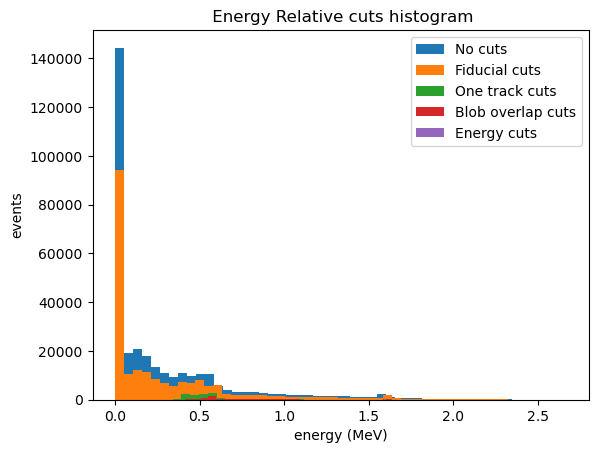

In [16]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50)
plot_hist(one_track_rel, label = 'One track cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'Blob overlap cuts', output = False, binning = 50)
plot_hist(ecut_rel, label = 'Energy cuts', output = False, title=' Energy Relative cuts histogram')
plt.legend()
plt.show()

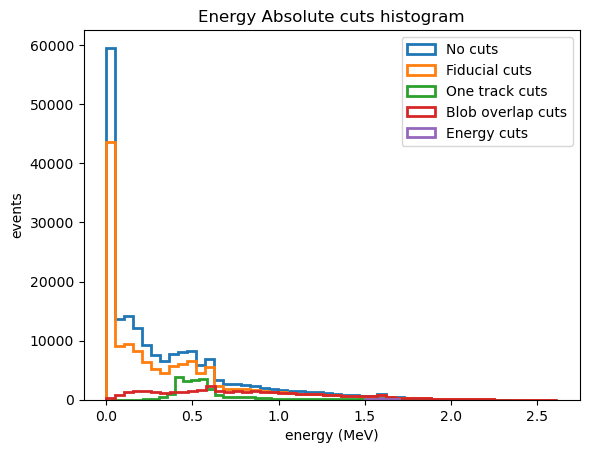

In [19]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50, fill = False)
plot_hist(fiducial, label = 'Fiducial cuts', output = False, binning = 50, fill = False)
plot_hist(one_track_abs, label = 'One track cuts', output = False, binning = 50, fill = False)
plot_hist(ovlp_abs, label = 'Blob overlap cuts', output = False, binning = 50, fill = False)
plot_hist(ecut_abs, label = 'Energy cuts', output = False, title='Energy Absolute cuts histogram', fill = False)
plt.legend()
plt.show()

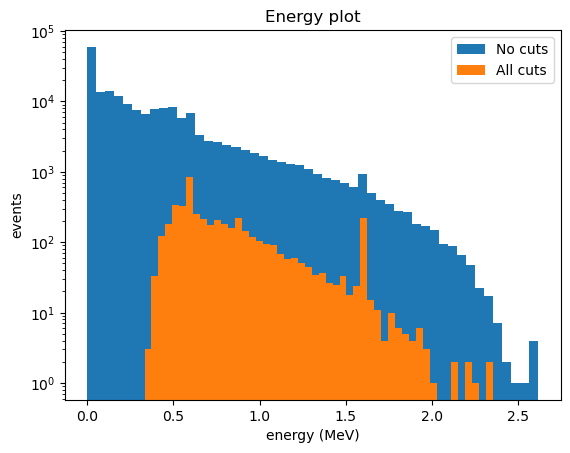

In [20]:
plot_hist(tracks, label = 'No cuts', output = False, binning = 50)
plot_hist(ovlp_rel, label = 'All cuts', output = False, binning = 50)
plt.yscale('log')
plt.legend()
plt.show()

# Collecting all e+e- events 

In [42]:
# create e+ dataframe only
positron_df = pd.DataFrame(columns=particles.columns)

condition = (particles['particle_name'] == 'e+')
positron_events = positron_df.append(particles.loc[condition], ignore_index=True)
print("True events with positrons:")
display(positron_events.head(20))

# collect events
pos_events = np.unique(positron_events['event_id'].to_numpy())
print("Total number of positron events: {}".format(len(pos_events)))
#print(pos_events)


# collect all events that dont match this list
ecut_no_positron_df = ecut_rel[~ecut_rel['event'].isin(pos_events)]

print("Isaura events with no positrons")
display(ecut_no_positron_df.head(20))

# events with positrons only in here!
ecut_positron_df = ecut_rel[ecut_rel['event'].isin(pos_events)]

print("Isaura events with positrons:")
display(ecut_positron_df.head(20))

# Check that we get all the data, should print true (which it does) 
print("Isaura events total: {}\nPositron Events: {}\nNon-positron events: {}\nDoes this add up? {}".format(len(ecut_rel),len(ecut_positron_df), len(ecut_no_positron_df), len(ecut_positron_df) + len(ecut_no_positron_df) == len(ecut_rel)))
print()

# make range full range of blob1 and blob2...
eblob_full = []
eblob_full.append(ecut_rel['eblob1'].to_numpy())
eblob_full.append(ecut_rel['eblob2'].to_numpy())

#...so that we can produce the min and max blob energy
minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)
#print(minimum_e, maximum_e)


True events with positrons:


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,5080012,28,e+,False,26,397.994476,406.192200,1104.511230,0.081588,397.663483,...,-0.113898,0.392981,-1.828005,0.0,0.0,-0.0,1.430683,1.431519,conv,annihil
1,5080018,36,e+,False,34,417.531311,434.714142,1134.706055,0.147440,417.572449,...,1.069797,0.628779,-0.066560,-0.0,0.0,-0.0,0.832645,0.483091,conv,annihil
2,5080036,35,e+,False,33,351.407288,195.293655,1046.552856,0.731658,388.764038,...,-0.395765,-1.658938,-0.268138,-0.0,0.0,-0.0,1.289479,415.102295,conv,annihil
3,5080046,39,e+,False,37,356.425354,-46.521172,775.359009,1.884820,364.295624,...,0.227442,-0.875990,-0.139887,0.0,-0.0,-0.0,0.537704,127.085846,conv,annihil
4,5080050,73,e+,False,71,234.638184,449.706116,1324.644409,0.869903,227.466187,...,-0.485283,-0.023844,1.693891,-0.0,0.0,0.0,1.323792,9.668751,conv,annihil
5,5080052,35,e+,False,28,-91.025848,112.043602,1145.507080,1.878903,-91.041824,...,0.010131,0.027123,-0.131806,0.0,-0.0,0.0,0.017519,0.444639,conv,annihil
6,5080072,26,e+,False,24,408.201385,382.348083,1073.564941,0.168765,408.201538,...,0.033001,0.089987,-0.073555,0.0,0.0,-0.0,0.014089,0.000803,conv,annihil
7,5080078,35,e+,False,33,300.882874,-310.088806,982.452332,2.425966,286.522003,...,0.355979,-0.720708,0.146069,-0.0,0.0,-0.0,0.452639,51.837307,conv,annihil
8,5080096,24,e+,False,22,-143.074844,-294.440796,307.402802,4.008312,-144.614014,...,-0.447561,-0.165490,-0.002644,-0.0,0.0,-0.0,0.188161,29.673340,conv,annihil
9,5080106,27,e+,False,25,389.023590,403.198334,1131.891724,0.032562,388.976562,...,-0.829231,1.450126,0.461114,-0.0,-0.0,0.0,1.295721,1.101717,conv,annihil


Total number of positron events: 9662
Isaura events with no positrons


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
3,5080002,0,1.655023,52.022880,62,5758,1,87.675,412.675,1114.557129,...,1138.384607,116.737695,412.787548,1116.362275,0.950188,0.090829,0.0,10.000000,8.714286,4.458588
5124,3900420,0,1.689774,160.336061,116,6433,1,-46.325,-153.325,751.298706,...,794.724386,64.777887,-131.075603,753.975622,0.576319,0.390139,0.0,9.833333,10.000000,4.716803
12361,3560452,0,1.667815,237.092209,140,6815,1,-81.325,88.675,309.259155,...,332.699973,-50.792647,94.950329,312.059043,0.518023,0.461178,0.0,9.181818,9.619048,4.979492
15130,2820472,0,1.688255,158.369148,121,6397,1,-207.325,-143.325,803.789429,...,849.873150,-200.347325,-108.656164,806.347796,0.506423,0.378851,0.0,9.500000,9.833333,4.824060
27237,1580190,0,1.575490,66.666093,82,6340,1,370.675,112.675,1029.529907,...,1031.100763,393.622957,120.245676,1070.911892,0.702632,0.027916,0.0,9.571429,9.250000,4.721570
28742,4440288,0,1.585606,129.735595,131,6892,1,181.675,277.675,965.492371,...,1009.612375,293.659898,340.660900,971.773421,0.141750,0.061539,0.0,9.857143,9.250000,4.825879
31430,3000318,0,1.511211,150.454731,117,6882,1,-51.325,-129.325,133.894577,...,224.918939,-20.175422,-123.711659,136.313237,0.357297,0.314585,0.0,9.333333,9.333333,4.967513
37168,3820230,0,1.553783,178.617231,152,6116,1,-131.325,-287.325,574.879883,...,665.458942,-125.249279,-271.710682,583.782882,0.639966,0.026817,0.0,9.142857,9.250000,4.915402
42582,1040182,0,1.500601,154.478904,142,6596,1,142.675,178.675,1109.331421,...,1148.778648,210.055599,317.246745,1129.807692,0.131814,0.013865,0.0,9.454545,10.000000,4.662774
51818,1680170,0,1.649399,183.136953,149,6876,1,91.675,-304.325,76.184998,...,79.095308,209.553570,-287.402816,154.390233,0.557161,0.109079,0.0,9.846154,9.700000,4.749381


Isaura events with positrons:


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
1716,3580364,0,1.593692,72.421034,101,6962,1,12.675,188.675,1122.988525,...,1125.707051,20.486813,203.555333,1163.440676,0.367297,0.258254,0.0,9.833333,9.000000,4.893975
2601,3260012,0,1.600612,173.068199,133,7141,1,96.675,-299.325,398.507111,...,423.100372,114.680619,-254.166408,463.007313,0.549444,0.279998,0.0,10.000000,9.222222,4.793878
2715,3260106,0,1.595215,70.297552,98,7422,1,-192.325,37.675,888.828430,...,915.675660,-186.849171,96.157919,915.552644,0.843625,0.213118,0.0,9.000000,9.285714,4.981316
3018,3260320,0,1.600568,187.019661,101,7188,1,-242.325,-274.325,454.153534,...,456.598826,-221.649377,-142.226550,517.030014,0.401444,0.327780,0.0,9.600000,9.666667,4.718787
3608,80316,0,1.598567,146.093980,128,6466,1,-282.325,167.675,857.340576,...,881.248188,-212.238441,265.186644,884.164284,0.541096,0.276916,0.0,9.600000,9.363636,4.585632
4010,20084,0,1.600641,195.662569,143,6565,1,144.675,-179.325,1109.323242,...,1130.400090,159.481886,-56.954820,1111.003389,0.494483,0.151007,0.0,9.571429,9.923077,4.547580
4063,20132,0,1.600693,115.653510,107,6019,1,47.675,14.675,1017.962036,...,1083.651393,102.038798,68.960507,1018.906494,0.323470,0.039643,0.0,9.285714,9.666667,4.948111
4625,3900040,0,1.592504,154.268022,112,6604,1,73.675,-69.325,1158.703735,...,1186.474042,217.289173,-64.906324,1174.145581,0.413601,0.384227,0.0,9.437500,8.750000,4.491438
8321,2020296,0,1.587827,95.385552,96,6726,1,61.675,-149.325,948.689026,...,951.429618,67.181911,-102.929348,978.092798,0.569946,0.556616,0.0,9.444444,9.666667,4.825659
9184,240378,0,1.593815,109.054542,108,6129,1,-125.325,207.675,765.973083,...,831.926053,-100.459956,208.438010,765.973083,0.322606,0.111068,0.0,9.400000,9.600000,4.722179


Isaura events total: 289
Positron Events: 245
Non-positron events: 44
Does this add up? True



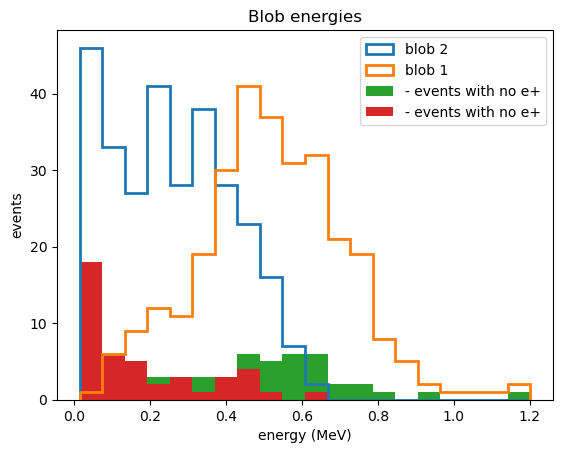

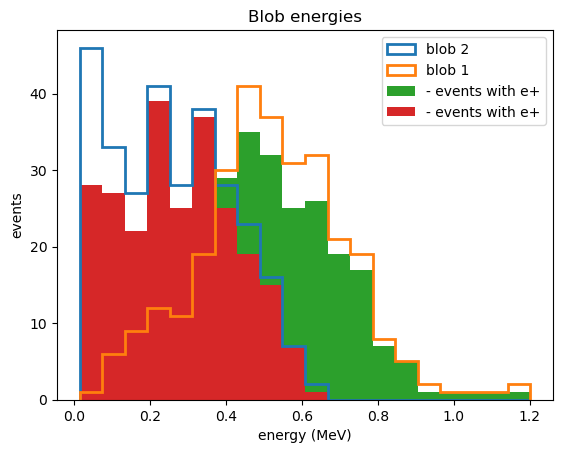

In [43]:

these_bins = 20
# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_no_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_no_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

# the original way
plot_hist(ecut_rel, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_rel, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

#plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
#plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

plot_hist(ecut_positron_df, column = 'eblob1', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
plot_hist(ecut_positron_df, column = 'eblob2', binning = these_bins, title = "Blob energies", output = False, fill = True, label = '- events with e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

plt.legend()
plt.show()

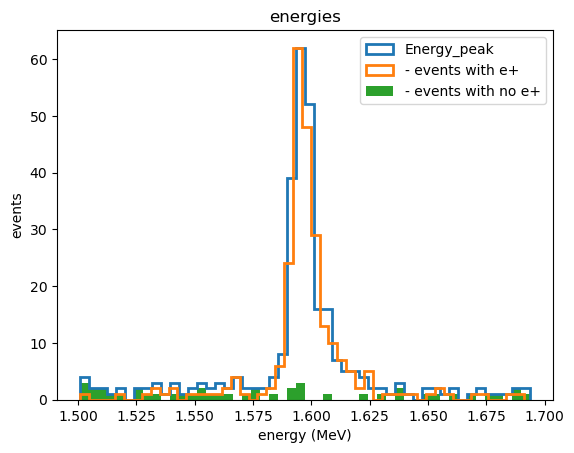

In [53]:
plot_hist(ecut_rel, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = 'Energy_peak', x_label = 'energy (MeV)')
plot_hist(ecut_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = False, label = '- events with e+', x_label = 'energy (MeV)')
plot_hist(ecut_no_positron_df, column = 'energy', binning = 50, title = "energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)')

plt.legend()
plt.show()

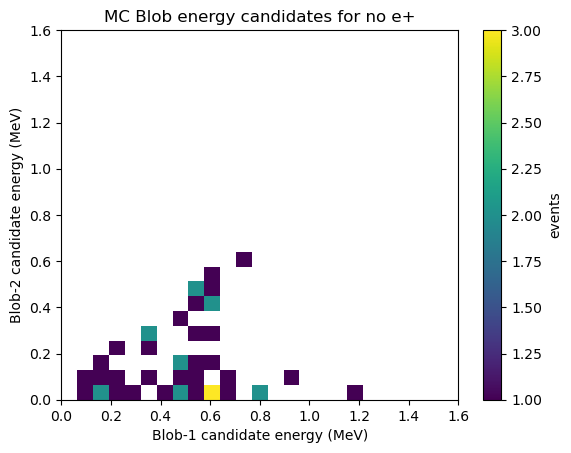

In [31]:
# plot the 2d histogram of blob energies for no positron data
# blob 2dhist
plt.hist2d(ecut_no_positron_df['eblob1'], ecut_no_positron_df['eblob2'], bins=(25, 25), range=((0, 1.6), (0, 1.6)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title("MC Blob energy candidates for no e+")
plt.show()

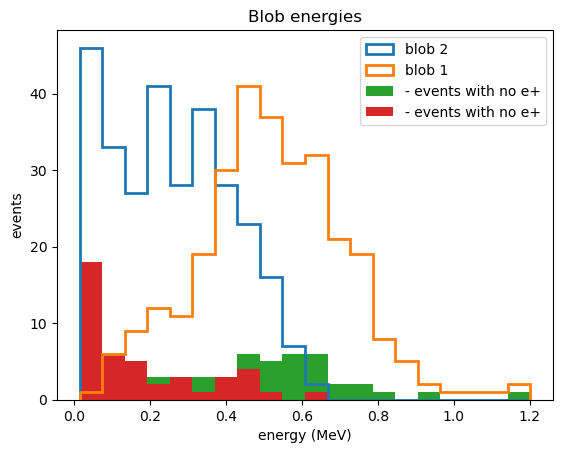

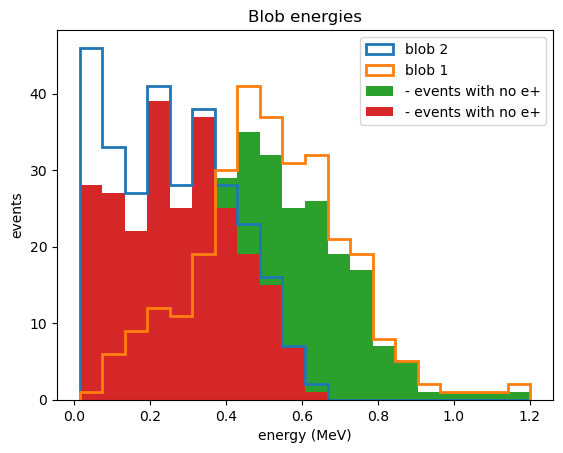

In [47]:
def blob_positron_plot(ecut_rel, ecut_no_positron_df, save = False, save_title = 'plot.png'):
    '''
    Plots the blob energies with and without positrons.
    '''

    # the original way
    plot_hist(ecut_rel, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_rel, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    #plt.hist(no_pos_blob1, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))
    #plt.hist(no_pos_blob2, bins = 20, label = 'events with no e+', range = (minimum_e, maximum_e))

    plot_hist(ecut_no_positron_df, column = 'eblob1', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))
    plot_hist(ecut_no_positron_df, column = 'eblob2', binning = 20, title = "Blob energies", output = False, fill = True, label = '- events with no e+', x_label = 'energy (MeV)', range = (minimum_e, maximum_e))

    plt.legend()

    if (save == True):
        plt.savefig(save_title)
    plt.show()

blob_positron_plot(ecut_rel, ecut_no_positron_df)
blob_positron_plot(ecut_rel, ecut_positron_df)

# Now to readadapt the code to give true FOM from sig and background while adjusting the cut location.

In [56]:


def true_fom_calc(p_data, no_p_data, cut_list, verbose = False):
    '''
    produces a figure of merit list based
    on cuts to specific categories and their
    consequent fits

    '''

    # create deep copies for safety
    pos_data = p_data.copy(deep = True)
    no_pos_data = no_p_data.copy(deep = True)

    if (verbose == True):
        blob_positron_plot(pos_data, no_pos_data)
    # Take the initial, no blob2 cut values for ns and nb
    ns0 = len(pos_data.index)
    nb0 = len(no_pos_data.index)
    # create all the lists for fom
    e = []
    b = []
    fom = []

    for i in range(len(cut_list)):
        
        # remove blob 2 values below value on cut_list
        pos_data = pos_data[(pos_data['eblob2'] > cut_list[i])]
        no_pos_data = no_pos_data[(no_pos_data['eblob2'] > cut_list[i])]


        # apply fit to the new data 
        if (verbose == True):
            print("Signal events: {}\nBackground events: {}\n FOM: {}".format())
        
        # collect number of signal events vs number of backgrounds, which you know 
        ns = len(pos_data.index)
        nb = len(no_pos_data.index)

        # produce fom value
        e.append(ns/ns0)
        b.append(nb/nb0)
        fom.append(e[i]/np.sqrt(b[i]))

        if (verbose == True):
            blob_positron_plot(pos_data, no_pos_data)
        
    # that should be it? i dont expect this to work first time, but lets test it!
    return fom

In [57]:
cut_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom = true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

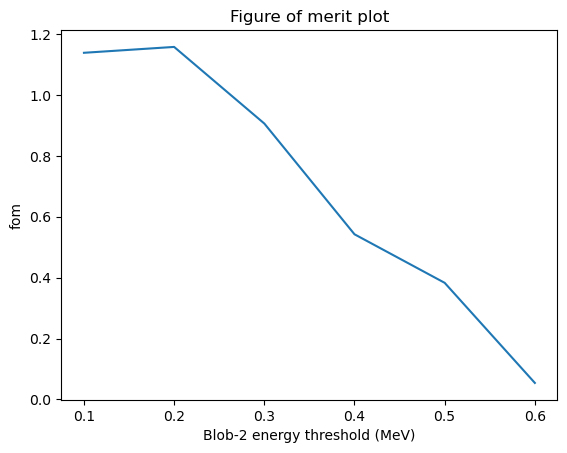

In [58]:
# plot fom
plt.plot(cut_list, fom)
plt.title("Figure of merit plot")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()